In [15]:
import numpy as np
import pandas as pd
import datetime
from scipy import stats
import math
import matplotlib.pyplot as plt
from statistics import mean
from tqdm import tqdm

In [2]:
sd = pd.read_csv("stock_data.csv")
ti = pd.read_csv("ticker_info.csv")

In [6]:
ti.drop('Unnamed: 0', axis=1, inplace=True)
sd['date'] = pd.to_datetime(sd['date'])
sd.shape

(10129344, 18)

In [7]:
# Construct joined_adj_close.csv

sdnew = pd.DataFrame()
for count, t in enumerate(tickers):
    df = pd.DataFrame(sd[sd['ticker']==t]['close'])
    df = df.rename(columns = {'close': t})
    sdnew = sdnew.join(df, how='outer')
sdnew.to_csv('joined_adj_close.csv')

In [6]:
df = pd.read_csv('joined_adj_close.csv')
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Remove "stocks experiencing financial distress"
sus_tickers = ti[ti['company_name'].apply(lambda x: 'ST' in x) == True]['ticker'].values
for col in list(df.columns):
    if col in sus_tickers:
        df.drop(col,axis=1,inplace=True)
df.head()

,sh600000,sh600004,sh600006,sh600007,sh600008,sh600009,sh600010,sh600011,sh600012,sh600015,...,sz301236,sz301237,sz301248,sz301256,sz301258,sz301259,sz301263,sz301268,sz301279,sz301288
date,,,,,,,,,,,,,,,,,,,,,
2005-01-04,0.76,3.30,1.82,3.12,1.08,10.28,0.55,2.99,2.57,1.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-05,0.75,3.36,1.84,3.18,1.09,10.38,0.55,2.95,2.59,1.08,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-06,0.74,3.36,1.82,3.15,1.08,10.43,0.55,2.91,2.64,1.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-07,0.74,3.43,1.82,3.21,1.09,10.55,0.55,2.92,2.64,1.07,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-10,0.77,3.44,1.84,3.27,1.10,10.56,0.56,2.89,2.68,1.10,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [237]:
pretrain = df.loc[:pd.Timestamp('2010-12-31')]
train = df.loc[pd.Timestamp('2011-01-01'):pd.Timestamp('2020-12-31')]
val = df.loc[pd.Timestamp('2021-01-01'):pd.Timestamp('2021-12-31')]
test = df.loc[pd.Timestamp('2022-01-01'):pd.Timestamp('2022-05-11')]

## Choosing tickers with highest Price-momentum

In [334]:
def price_momentum_selection(df, count=50):
    tickers = df.columns
    hqm_columns = [
                'Ticker', 
                'One-Year Price Return', 
                'One-Year Return Percentile',
                'Six-Month Price Return',
                'Six-Month Return Percentile',
                'Three-Month Price Return',
                'Three-Month Return Percentile',
                'One-Month Price Return',
                'One-Month Return Percentile',
                'HQM Score'
                ]
    hqm_dataframe = pd.DataFrame(columns = hqm_columns)
    hqm_dataframe['Ticker'] = tickers
    hqm_dataframe.set_index('Ticker', inplace=True)
    
    time_periods = [
                'One-Year',
                'Six-Month',
                'Three-Month',
                'One-Month'
                ]
    freq = ''

    for row in tqdm(hqm_dataframe.index):
        momentum_percentiles = []
        for time_period in time_periods:
            if time_period == 'One-Year': freq='Y'
            if time_period == 'Six-Month': freq='6M'
            if time_period == 'Three-Month': freq='3M'
            if time_period == 'One-Month': freq='M'
            hqm_dataframe.loc[row, f'{time_period} Price Return'] = df[row].resample(freq).apply(lambda x: x[-1]).pct_change()[-1]
            hqm_dataframe.loc[row, f'{time_period} Return Percentile'] = stats.percentileofscore(hqm_dataframe[f'{time_period} Price Return'], hqm_dataframe.loc[row, f'{time_period} Price Return'])/100
            momentum_percentiles.append(hqm_dataframe.loc[row, f'{time_period} Return Percentile'])
        hqm_dataframe.loc[row, 'HQM Score'] = mean(momentum_percentiles)  
    
    hqm_dataframe = hqm_dataframe.sort_values(by = 'HQM Score', ascending = False)[:count]
    return hqm_dataframe

In [335]:
top_momentum = price_momentum_selection(train)

  0%|                                                                                         | 0/4511 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1950: RuntimeWarning: invalid value encountered in less
  left = np.count_nonzero(a < score)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1951: RuntimeWarning: invalid value encountered in less_equal
  right = np.count_nonzero(a <= score)
100%|██████████████████████████████████████████████████████████████████████████████| 4511/4511 [01:11<00:00, 63.18it/s]


In [336]:
def num_shares(df, ticker, initial_capital=100000.0):
    position_size = float(initial_capital) / len(top_momentum.index)
    num_sh = math.floor(position_size / df[ticker][0])
    return num_sh

## Signal generation based on Two moving averages strategy

In [337]:
def ticker_signal(series, short_window=7, long_window=30):
    signals = pd.DataFrame(index=series.index)
    signals['signal'] = 0.0
    signals['short_mavg'] = series.rolling(window=short_window, min_periods=1, center=False).mean()
    signals['long_mavg'] = series.rolling(window=long_window, min_periods=1, center=False).mean()
    signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)
    return signals['signal']

In [338]:
def generate_signals(df, short_window=7, long_window=30):
    selected_tickers = top_momentum.index
    signals = pd.DataFrame(index=df.index)
    for st in tqdm(selected_tickers):
        signals[st] = ticker_signal(df[st], short_window, long_window)
    return signals

In [352]:
top_signals = generate_signals(val, short_window=60, long_window=100)

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 337.85it/s]


In [353]:
def make_portfolio(df, initial_capital=100000.0):
    selected_tickers = top_momentum.index
    positions = pd.DataFrame(index=df.index)
    pos_diff = pd.DataFrame(index=df.index)
    for ticker in tqdm(selected_tickers):
        positions[ticker] = num_shares(df, ticker)*top_signals[ticker]
        pos_diff[ticker] = positions[ticker].diff().multiply(df[ticker], axis=0)
        positions[ticker] = positions[ticker].multiply(df[ticker], axis=0)
    portfolio = pd.DataFrame(index=df.index)
    portfolio['holdings'] = positions.sum(axis=1)
    portfolio['cash'] = initial_capital - pos_diff.sum(axis=1).cumsum(skipna=True)
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']
    portfolio['returns'] = portfolio['total'].pct_change()
    return portfolio

top_portfolio = make_portfolio(val)

100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 694.21it/s]


In [354]:
top_portfolio

,holdings,cash,total,returns
date,,,,
2021-01-04,0.00,100000.00,100000.00,NaN
2021-01-05,0.00,100000.00,100000.00,0.000000
2021-01-06,0.00,100000.00,100000.00,0.000000
2021-01-07,0.00,100000.00,100000.00,0.000000
2021-01-08,0.00,100000.00,100000.00,0.000000
...,...,...,...,...
2021-12-27,68151.78,57517.55,125669.33,0.002530
2021-12-28,69600.49,57517.55,127118.04,0.011528
2021-12-29,73443.88,53592.96,127036.84,-0.000639


## Evaluation

In [355]:
def portfolio_price(df):
    cum_portfolio_price = pd.DataFrame(index=df.index)
    for ticker in selected_tickers:
        cum_portfolio_price[ticker] = df[ticker] * num_shares(df,ticker)
    cum_portfolio_price['Sum'] = cum_portfolio_price.sum(axis=1)
    return cum_portfolio_price['Sum']

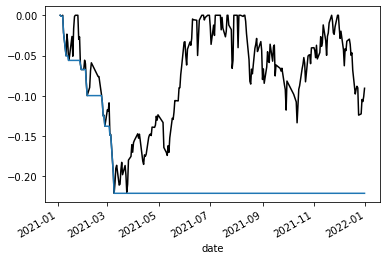

In [356]:
window = 252
cum_portfolio_price = portfolio_price(val)
rolling_max = cum_portfolio_price.rolling(window, min_periods=1).max()
daily_drawdown = cum_portfolio_price/rolling_max - 1.0

max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

daily_drawdown.plot(color='k')
max_daily_drawdown.plot()

plt.show()

In [357]:
returns = top_portfolio['returns']
sharpe_ratio = np.sqrt(window) * (returns.mean() / returns.std())
print('Sharpe ratio:' , sharpe_ratio)

df_daily_returns = returns[1:]
df_cum_daily_returns = (1 + df_daily_returns).cumprod() - 1
df_cum_daily_returns = df_cum_daily_returns.reset_index()
cum_return_entire_period = df_cum_daily_returns.iloc[-1, 1]
romad = cum_return_entire_period / abs(max_daily_drawdown.min())
print('RoMaD: ', romad)

Sharpe ratio: 1.3153268770586626
RoMaD:  1.2995767480237506


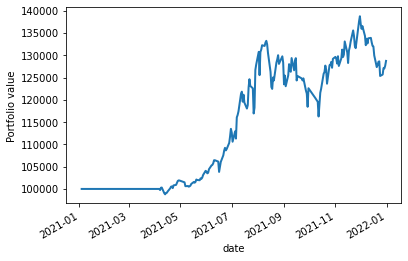

In [358]:
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Portfolio value')
top_portfolio['total'].plot(ax=ax1, lw=2.)
plt.show()

## Test

  0%|                                                                                         | 0/4511 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1950: RuntimeWarning: invalid value encountered in less
  left = np.count_nonzero(a < score)
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1951: RuntimeWarning: invalid value encountered in less_equal
  right = np.count_nonzero(a <= score)
100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:00<00:00, 892.87it/s]


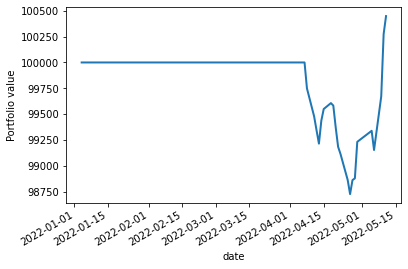

In [359]:
top_momentum = price_momentum_selection(df.loc[pd.Timestamp('2012-01-01'):pd.Timestamp('2021-12-31')])
top_signals = generate_signals(test, short_window=60, long_window=100)
top_portfolio = make_portfolio(test)
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Portfolio value')
top_portfolio['total'].plot(ax=ax1, lw=2.)
plt.show()

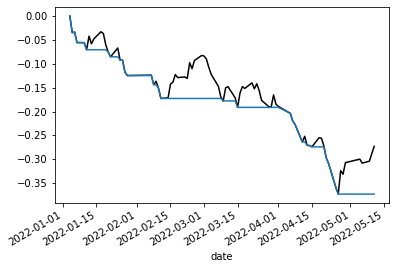

In [360]:
window = 252
cum_portfolio_price = portfolio_price(test)
rolling_max = cum_portfolio_price.rolling(window, min_periods=1).max()
daily_drawdown = cum_portfolio_price/rolling_max - 1.0

max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

daily_drawdown.plot(color='k')
max_daily_drawdown.plot()

plt.show()

In [361]:
returns = top_portfolio['returns']
sharpe_ratio = np.sqrt(window) * (returns.mean() / returns.std())
print('Sharpe ratio:' , sharpe_ratio)

df_daily_returns = returns[1:]
df_cum_daily_returns = (1 + df_daily_returns).cumprod() - 1
df_cum_daily_returns = df_cum_daily_returns.reset_index()
cum_return_entire_period = df_cum_daily_returns.iloc[-1, 1]
romad = cum_return_entire_period / abs(max_daily_drawdown.min())
print('RoMaD: ', romad)

Sharpe ratio: 0.7070295896081445
RoMaD:  0.012049380360543812


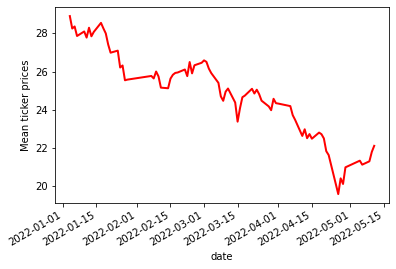

In [370]:
fig = plt.figure()
ax1 = fig.add_subplot(111, ylabel='Mean ticker prices')
test.mean(axis=1).plot(ax=ax1, lw=2., color='r')
plt.show()

In [368]:
top_momentum

,One-Year Price Return,One-Year Return Percentile,Six-Month Price Return,Six-Month Return Percentile,Three-Month Price Return,Three-Month Return Percentile,One-Month Price Return,One-Month Return Percentile,HQM Score
Ticker,,,,,,,,,
sz300818,0.572247,0.699845,0.705212,0.846597,0.538462,0.866992,0.379503,0.88517,0.824651
sz300911,0.977311,0.798271,0.705601,0.866105,0.325566,0.821991,0.128219,0.785413,0.817945
sz300799,0.629681,0.714476,0.43249,0.777433,1.209166,0.892485,0.389299,0.882731,0.816781
sz300636,0.877493,0.7362,0.73764,0.816005,0.700645,0.847041,0.409626,0.851031,0.812569
sz300860,0.241177,0.550654,0.828695,0.868765,1.173333,0.904899,0.773964,0.909333,0.808413
sz300813,1.045408,0.78497,0.324503,0.72423,0.586798,0.871647,0.169317,0.813345,0.798548
sz300776,0.713884,0.731988,0.309085,0.70716,0.848187,0.882066,0.267334,0.858568,0.794946
sz300412,1.539568,0.737309,1.736434,0.797606,2.08875,0.813345,0.883384,0.815784,0.791011
sz300902,0.258321,0.56861,0.659018,0.855464,0.797993,0.906229,0.148231,0.808912,0.784804
